# **Lab Session : Feature selection I**


Author: Vanessa Gómez Verdejo (http://vanessa.webs.tsc.uc3m.es/)

Updated: 19/04/2017 (working with sklearn 0.18.1)

In this lab session we are going to study filtering methods for feature selection. To analyze their performances we will work with the Olivetti face detection problem. 

#### ** During this lab we will cover: **
#### *Part 1: Filter methods for feature selection* 
##### *   Part 1.1: F-score* 
##### *   Part 1.2: Mutual Information* 
##### *   Part 1.3: Random Forest* 
#### *Part 2: Advanced work:*
    1. HSIC 
    2. MRmr
#### *Part 3: More advanced work: search algorithms* 

To implement the different approaches we will base on [Scikit-Learn](http://scikit-learn.org/stable/) python toolbox.

As you progress in this notebook, you will have to complete some exercises. Each exercise includes an explanation of what is expected, followed by code cells where one or several lines will have written down `<FILL IN>`.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.  Once the `<FILL IN>` sections are updated and the code can be run; below this cell, you will find the test cell (beginning with the line `# TEST CELL`) and you can run it to verify the correctness of your solution.  

In [1]:
%matplotlib inline

## ** Part 0: Download and prepare the data **

Olivetti dataset consists of ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).
    
The next code includes the lines to download this data set and create the training, validation and test data partitions, as well as normalize them.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces 
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
print 'The first time that you downlaod the data it can take a while...'
olivetti_people = fetch_olivetti_faces()

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = olivetti_people.images.shape

# for machine learning we use the data directly (as relative pixel
# positions info is ignored by this model)
X = olivetti_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
Y = olivetti_people.target
n_classes = np.unique(Y).shape[0]

print("Dataset size information:")
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Preparing the data

# Initialize the random generator seed to compare results
np.random.seed(1)

# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

# split into a training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.333)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Binarize the labels for some feature selection methods
set_classes = np.unique(Y)
Y_train_bin = label_binarize(Y_train, classes=set_classes)

print("Number of training samples: %d" % X_train.shape[0])
print("Number of validation samples: %d" % X_val.shape[0])
print("Number of test samples: %d" % X_test.shape[0])

The first time that you downlaod the data it can take a while...
Dataset size information:
n_features: 4096
n_classes: 40
Number of training samples: 200
Number of validation samples: 100
Number of test samples: 100


## ** Part 1: Filtering methods **

Filtering methods are characterized for being independent from the subsequent classification stage, so they use a relevance criterion to measure the discriminatory capability of each feature and select or rank the input features according this criterion.

Here, we are going to study two possible approaches: 
* F-score (the F-test reduces to two-sample T-test when we work with binary problems): which uses a statistical test to evaluate whether the data of the different classes have been generated by different distributions or not. In this case, this criterion evaluates the relevance independently for each feature, so it is said to be univariate.
* Random Forest: in this case we can train a random forest and analyze the number of times that a feature have been used in the forest. More used features will be more relevant. In this case the relevance of a feature is analyzed in combination with the remaining ones (each tree of the forest use several features and the fact that one is selected depends on the those selected previously), so this feature selection criterion is call multivariate.

After selecting the subset of relevant features, we will analyze their discriminatory capability using a linear SVM as classifier and use its final test accuracy to evaluate the goodness of the different selection methods.


### ** Part 1.1: F-score **

Use the [f_classif()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html) method to obtain the F-score of each input feature (each pixel of the face image). Use the resulting values to rank the features by relevance (starting by the most relevant) and provide in ind\_rel\_feat the position of the sorted features (i.e. ind_rel_feat[0] has contain the position of the most relevant feature). 

In [3]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################

# F-score
from sklearn.feature_selection import f_classif
F, p = f_classif(X_train, Y_train)  # Returns F-score and their associated p values

# sort in descending order
ind_rel_feat = np.argsort(F)[::-1]
    
# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, ind_rel_feat[f], F[ind_rel_feat[f]]))

Feature ranking:
1. feature 19 (46.329731)
2. feature 148 (44.509853)
3. feature 18 (44.007832)
4. feature 17 (42.694084)
5. feature 150 (41.866787)
6. feature 24 (41.624760)
7. feature 147 (41.566883)
8. feature 83 (41.456051)
9. feature 87 (41.058460)
10. feature 20 (41.019909)


In [4]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(np.sum(ind_rel_feat[:5]- [ 19, 148,  18,  17, 150]),0, 'incorrect result: first positions of relevant features are uncorrect')

1 test passed.


Now, we are going to provide you two functions:
* SVM_accuracy_evolution( ) which analyzes the accuracy of a linear SVM when different number of features are used, specifically, those given by the input variable rang\_feat. Besides, it computes the training, validation and test accuracy, so we can later use these values to select the optimum number features and select the subset of relevant ones.
* plot_accuracy_evolution( ) which directly let you plot the results provided by  SVM_accuracy_evolution( ).

Note that you must provide to SVM_accuracy_evolution() the data with the variables sorted by relevance, so that the most relevant ones are used first.

In [5]:
from sklearn import svm

def SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat):
    """Compute the accuracy of training, validation and test data for different the number of features given
        in rang_feat.

    Args:
        X_train_s (numpy dnarray): training data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number data x 1).
        X_val_s (numpy dnarray): validation data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_val (numpy dnarray): labels of the validation data (number data x 1).
        X_test_s (numpy dnarray): test data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number data x 1).
        rang_feat: range with different number of features to be evaluated                                           
   
    """
    
    # Define the model to train a liner SVM and adjust by CV the parameter C
    clf = svm.SVC(kernel='linear')
    acc_tr = []
    acc_val = []
    acc_test = []
    for i in rang_feat:
        # Train SVM classifier
        clf.fit(X_train_s[:, :i], Y_train)
        # Compute accuracies
        acc_tr.append(clf.score(X_train_s[:, :i], Y_train))
        acc_val.append(clf.score(X_val_s[:, :i], Y_val))
        acc_test.append(clf.score(X_test_s[:, :i], Y_test))

    return np.array(acc_tr), np.array(acc_val), np.array(acc_test)


In [6]:
import matplotlib.pyplot as plt

def plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test):

    """Plot the accuracy evolution for training, validation and test data sets.
    Args:
        rang_feat: range with different number of features where the accuracy has been evaluated   
        acc_tr: numpy vector with the training accuracies
        acc_val: numpy vector with the validation accuracies
        acc_test: numpy vector with the test accuracies                                          
    """

    plt.plot(rang_feat, acc_tr, "b", label="train")
    plt.plot(rang_feat, acc_val, "g", label="validation")
    plt.plot(rang_feat, acc_test, "r", label="test")
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy")
    plt.title('Accuracy evolution')
    plt.legend(['Training', 'Validation', 'Test'], loc = 4)


Complete the following code lines to properly call to SVM\_accuracy\_evolution( ) function. Then, use the returned accuracies to validate the number of features to use and obtain its corresponding test accuracy.

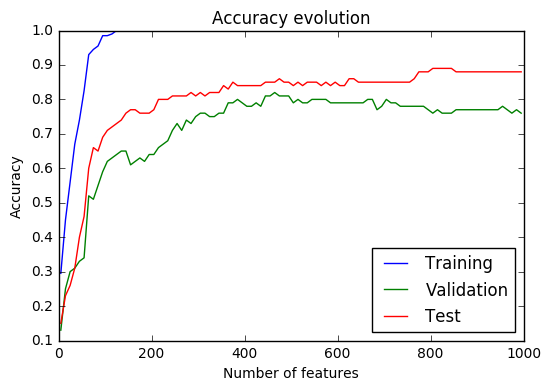

Number optimum of features: 465
The optimum test accuracy is  85.00%


In [7]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(5, 1000, 10) 
X_train_s = X_train[:,ind_rel_feat]
X_val_s = X_val[:,ind_rel_feat]
X_test_s = X_test[:,ind_rel_feat]
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat)

# Plot the results
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(acc_val)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print 'Number optimum of features: ' + str(num_opt_feat)
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

In [8]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(num_opt_feat,465, 'incorrect result: number of selected features is uncorrect')
Test.assertEquals(test_acc_opt,0.85, 'incorrect result: test error is uncorrect')

1 test passed.
1 test passed.


Finally, next function, plot_image( ), let you plot the image of any face of the data set. However, we can use it to plot the relevance of each pixel or just a mask indicating the selected input features. Next cell contains an example to plot the F-score values, complete the following code to plot a mask of the selected features after the validation process (i.e., create an image with 1 in the positions of the selected features and 0 in the positions of the non selected ones).

In [9]:
import matplotlib.pyplot as plt
def plot_image(image, h, w):
    """Helper function to plot a face image
    Args:
        image: numpy vector with the image to plot (of dimensions h*w)
        h: height of the image (in number of pixels)
        w: width of the image (in number of pixels)  """  
    
    plt.imshow(image.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    plt.colorbar()

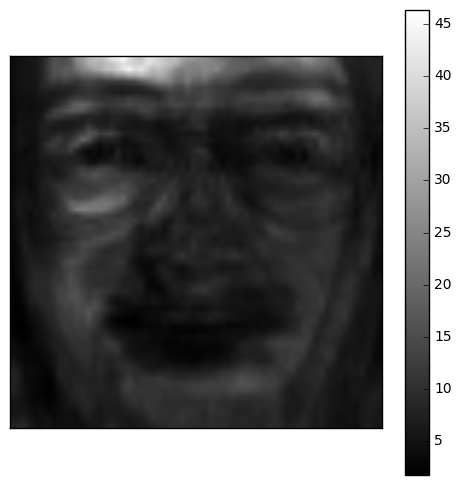

In [10]:
# Example to plot an image
plt.figure(figsize=(6,6))
plot_image(F, h, w)
plt.show()

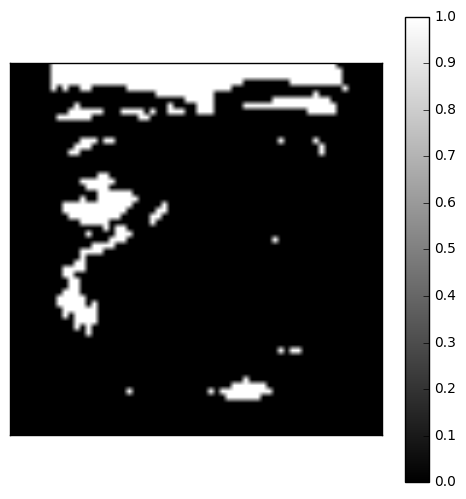

In [11]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################

# Create the mask of selected features
# Several lines to <FILL IN>

mask = np.zeros(len(F))
mask[ind_rel_feat[0:num_opt_feat]] = 1

# Plot it!
plt.figure(figsize=(6,6))
plot_image(mask, h, w)
plt.show()



### ** Part 1.2: Mutual Information **


Compute the MI between each input feature and the output labes to measure the relevance of each feature. Check the function [mutual_info_classif()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif).

Note: this MI estimator has a parameter (n_neighbors) which should be validated. You can use its default value for this experiment.

In [12]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn.feature_selection import mutual_info_classif

# Obtain MI values
MI = mutual_info_classif(X_train, Y_train, random_state =0)  # Returns MI values

# sort in descending order
ind_rel_feat = np.argsort(MI)[::-1]
    
# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, ind_rel_feat[f], MI[ind_rel_feat[f]]))

Feature ranking:
1. feature 86 (1.345058)
2. feature 150 (1.323448)
3. feature 147 (1.292987)
4. feature 83 (1.288698)
5. feature 85 (1.284265)
6. feature 84 (1.279955)
7. feature 18 (1.278868)
8. feature 87 (1.270546)
9. feature 19 (1.269821)
10. feature 149 (1.260650)


In [13]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(np.sum(ind_rel_feat[:5]- [ 86, 150, 147,  83,  85]),0, 'incorrect result: first positions of relevant features are uncorrect')

1 test passed.


Now, use the above the result to:
* Evaluate the linear SVM performance with the most relevant features are used (use SVM_accuracy_evolution( ) function). Plot the evolution of the training, validation and test accuracies.
* Obtain, using the validation accuracy, the optimum number of features to use.
* Create the mask with the selected features and plot it (you can use the plot_image( ) function).

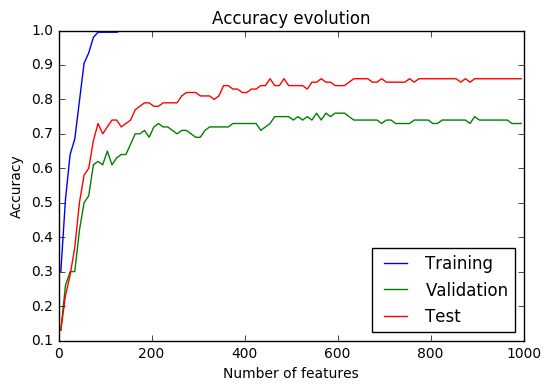

Number optimum of features: 555
The optimum test accuracy is  85.00%


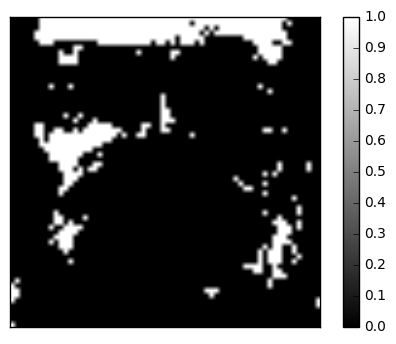

In [14]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(5, 1000, 10) 
X_train_s = X_train[:,ind_rel_feat]
X_val_s = X_val[:,ind_rel_feat]
X_test_s = X_test[:,ind_rel_feat]
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat)


# Plot the results
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(acc_val)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print 'Number optimum of features: ' + str(num_opt_feat)
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))
    
# Create and plot the mask
mask = np.zeros(len(F))
mask[ind_rel_feat[0:num_opt_feat]] = 1
plt.figure()
plot_image(mask, h, w)
plt.show()

In [15]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(num_opt_feat,555, 'incorrect result: number of selected features is uncorrect')
Test.assertEquals(test_acc_opt,0.85, 'incorrect result: test error is uncorrect')

1 test passed.
1 test passed.


### ** Part 1.3: Random Forest **

Train a random forest to obtain a measurement of the relevance of each feature. You can use the  [RandomForestClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) function, which returns the feature relevances in the variable .feature\_importances\_.


Complete the following code to:
* Train a random forest classifier with the parameters given by default and 250 trees.
* Use the forest feature importances to obtain a ranking with the most relevant features, save their positions in the variable  ind\_rel\_feat

In [16]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn.ensemble import RandomForestClassifier
np.random.seed(1)
# Build a forest and obtain the feature importances
forest = RandomForestClassifier(n_estimators=250)
forest.fit(X_train, Y_train)
importances = forest.feature_importances_

# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, ind_rel_feat[f], importances[ind_rel_feat[f]]))

Feature ranking:
1. feature 90 (0.002136)
2. feature 598 (0.002064)
3. feature 527 (0.001975)
4. feature 150 (0.001729)
5. feature 684 (0.001728)
6. feature 663 (0.001710)
7. feature 702 (0.001693)
8. feature 277 (0.001664)
9. feature 213 (0.001634)
10. feature 142 (0.001530)


In [17]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(np.sum(ind_rel_feat[:5]-  [ 90, 598,  527, 150, 684]),0, 'incorrect result: first positions of relevant features are uncorrect')

1 test passed.


Now, use the above the result to:
* Evaluate the linear SVM performance with the most relevant features are used (use SVM_accuracy_evolution( ) function). Plot the evolution of the training, validation and test accuracies.
* Obtain, using the validation accuracy, the optimum number of features to use.
* Create the mask with the selected features and plot it (you can use the plot_image( ) function).

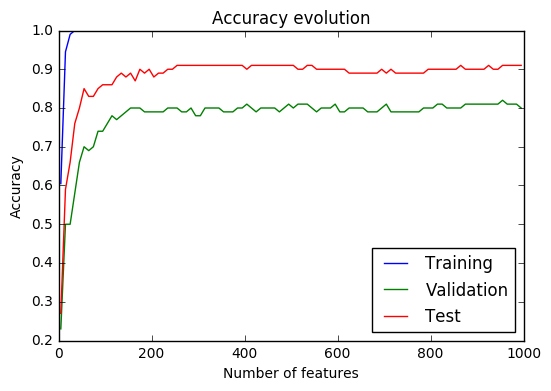

Number optimum of features: 955
The optimum test accuracy is  91.00%


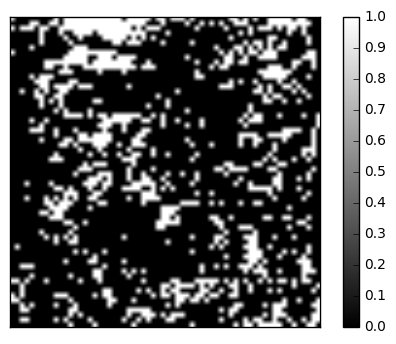

In [18]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(5, 1000, 10) # To speed up the execution, we use steps of 10 features.
X_train_s = X_train[:,ind_rel_feat]
X_val_s = X_val[:,ind_rel_feat]
X_test_s = X_test[:,ind_rel_feat]
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat)

# Plot it!
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(acc_val)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print 'Number optimum of features: ' + str(num_opt_feat)
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

# Create and plot the mask
mask = np.zeros(len(F))
mask[ind_rel_feat[0:num_opt_feat]] = 1
plt.figure()
plot_image(mask, h, w)
plt.show()

In [19]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(num_opt_feat,955, 'incorrect result: number of selected features is uncorrect')
Test.assertEquals(test_acc_opt,0.91, 'incorrect result: test error is uncorrect')

1 test passed.
1 test passed.


## ** Part 2: Advanced work **

In this section we are going to implement additional feature selection approaches which are not included in scikit-learn library.

In particular, we propose to implement 2 different schemes:
1. HSIC relevance measurement
2. MRmr (Maximum Relevance minimum redundance) approach


#### 1. HSIC relevance measurement

Here, you have two usefull functions:
1. estimate_gamma( ), which let you obtain a good estimation of the gamma value to be used by the kernel transformations. In this way, you can avoid validating this parameter.
2. center_K( ), which removes the mean of a kernel matrix in the feature space.

In [20]:
def estimate_gamma(X):
    """Estimate an appropiate valie of the gamma parameter to be used the build a RBF kernel with the data X
    Args:
        X: input data                             
    """
    size=X.shape[0];
    if X.ndim==1:
        X=X[:,np.newaxis]
        
    G=(X* X).sum(axis=1)
    KK=np.dot(X,X.T)
    
    R = np.tile(G, [size,1])
    Q = R.T
    
    dist=(Q + R - 2*KK)
   
    aux=dist-np.tril(dist)
    aux=aux.reshape(size**2,1)
    sig=np.sqrt(0.5*np.mean(aux[np.where(aux>0)]))  
    gamma = 1./sig**2  
    return gamma

In [21]:
def center_K(K):
    """Center a kernel matrix K, i.e., removes the data mean in the feature space.

    Args:
        K: kernel matrix                                        
    """
    size_1,size_2 = K.shape;
    D1 = K.sum(axis=0)/size_1 
    D2 = K.sum(axis=1)/size_2
    E = D2.sum(axis=0)/size_1

    K_n = K + np.tile(E,[size_1,size_2]) - np.tile(D1,[size_1,1]) - np.tile(D2,[size_2,1]).T
    return K_n

Now, considering that the HSIC value between a input feature $\textbf{X}$ and an output variable $\textbf{Y}$ with length $N$ is given by:
$$ \text{HSIC}(\textbf{X},\textbf{Y}) = \dfrac{1}{N^2} \text{Tr}(\tilde{K}_x \tilde{K}_y)$$
where $\tilde{K}_x$ and $\tilde{K}_y$ are the centered kernel matrices of the corresponding input variables $\textbf{X}$ and $\textbf{Y}$, complete the following code:

In [22]:
def rbf_kernel_sig(X1, X2, sig=0):
    size1=X1.shape[0];
    size2=X2.shape[0];
    if X1.ndim==1:
        X1=X1[:,np.newaxis]
        X2=X2[:,np.newaxis]
    G=(X1* X1).sum(axis=1)
    H=(X2* X2).sum(axis=1)
    Q = np.tile(G, [size2,1]).T
    R = np.tile(H, [size1,1])
    KK=np.dot(X1,X2.T)
    dist=(Q + R - 2*KK)
    if sig==0:  # Then, we estimate its value
        aux=dist-np.tril(dist)
        aux=aux.reshape(size1**2,1)
        sig=np.sqrt(0.5*np.mean(aux[np.where(aux>0)]))             
    K = np.exp(-dist/sig**2);
    return K, sig

In [23]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################

from sklearn.metrics.pairwise import rbf_kernel

def HSIC_rbf(X, Y):
    """Compute HSIC value between input and output data using a RBF kernel

    Args:
        X: input data
        Y: output data
    """
    if X.ndim==1:
        X=X[:,np.newaxis]
    if Y.ndim==1:
        Y=Y[:,np.newaxis]
    # 1. Estimate gamma value for X and Y
    gamma_x = estimate_gamma(X)
    gamma_y = estimate_gamma(Y)
    
    # 2. Compute kernel matrices
    K_x,g = rbf_kernel_sig(X,X)
    K_y,g = rbf_kernel_sig(Y,Y)
    
    # 3. Center kernel matrices
    K_xc = center_K(K_x)
    K_yc = center_K(K_y)
    
    # 4. Compute HSIC value
    N = len(Y_train)
    HSIC= N**(-2)*np.trace(np.dot(K_xc,K_yc))
    return HSIC

# Test HSIC function
i_test = 90
HSIC=HSIC_rbf(X_train[:,i_test], Y_train_bin)
print HSIC

0.0082815619942


In [24]:
###########################################################
# TEST CELL
###########################################################
from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(np.round(HSIC,4), 0.0083, 'incorrect result: HSIC funtion does not work properly')

1 test passed.


In [25]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Compute HSIC relevances
importances=np.zeros(X_train.shape[1])
for i in range(X_train.shape[1]):
    importances[i]= HSIC_rbf(X_train[:,i], Y_train_bin)
    
# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, ind_rel_feat[f], importances[ind_rel_feat[f]]))

Feature ranking:
1. feature 1674 (0.009327)
2. feature 1555 (0.009279)
3. feature 1616 (0.009265)
4. feature 1554 (0.009218)
5. feature 1675 (0.009209)
6. feature 1551 (0.009205)
7. feature 1553 (0.009120)
8. feature 1615 (0.009118)
9. feature 1676 (0.009106)
10. feature 1617 (0.009105)


In [26]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(np.sum(ind_rel_feat[:5]-  [ 1674, 1555,  1616,  1554, 1675]),0, 'incorrect result: first positions of relevant features are uncorrect')

1 test passed.


Now, use the above the result to:
* Evaluate the linear SVM performance with the most relevant features are used (use SVM_accuracy_evolution( ) function). Plot the evolution of the training, validation and test accuracies.
* Obtain, using the validation accuracy, the optimum number of features to use.
* Create the mask with the selected features and plot it (you can use the plot_image( ) function).

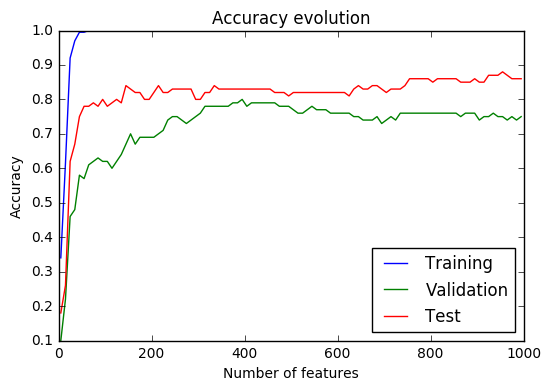

Number optimum of features: 395
The optimum test accuracy is  83.00%


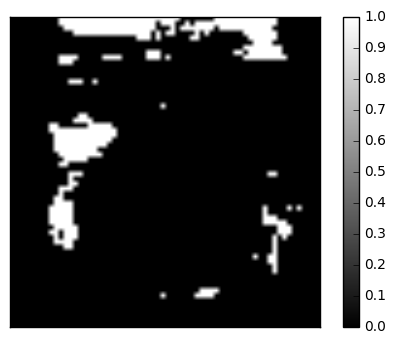

In [27]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(5, 1000, 10) # To speed up the execution, we use steps of 10 features.


X_train_s = X_train[:,ind_rel_feat]
X_val_s = X_val[:,ind_rel_feat]
X_test_s = X_test[:,ind_rel_feat]
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat)



# Plot it!
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(acc_val)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print 'Number optimum of features: ' + str(num_opt_feat)
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

# Create and plot the mask
mask = np.zeros(len(F))
mask[ind_rel_feat[0:num_opt_feat]] = 1
plt.figure()
plot_image(mask, h, w)
plt.show()

In [28]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(num_opt_feat,395, 'incorrect result: number of selected features is uncorrect')
Test.assertEquals(test_acc_opt,0.83, 'incorrect result: test error is uncorrect')

1 test passed.
1 test passed.


#### 2. MRmr

In this section let's implement a Maximum Relevance minimum redundance (MRmr) approach to use univariate relevance measurements in a multivariate fashion. In particular, let's use:
1. **f_classif** as relevance criterion.
2. **correlation** as redundancy measurement.


In [46]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################

from sklearn.feature_selection import f_classif

# Variable initialization
n_var = X_train.shape[1]
var_sel = np.empty(0,dtype=int) # subset of selected features
var_cand = np.arange(n_var) # subset of candidate features

# Precompute relevances (f_classif value of all input variables wiht output variable)
relevances,p = f_classif(X_train, Y_train)

# Precomupute redundancies (correlation among all input variables, it is a matrix of n_var x n_var)
#redundancies = np.dot(X_train.T, X_train)
redundancies = np.corrcoef(np.transpose(X_train))

# Select the most relevant feature (the one with maximum relevance)
sel = np.argmax(relevances)
print sel
# Add it to the subset of selected features
var_sel = np.hstack((var_sel, sel))
# Remove it from the subset of candidate features
var_cand = np.delete(var_cand, sel)
print np.shape(var_cand)
print var_sel
print var_cand

19
(4095,)
[19]
[   0    1    2 ..., 4093 4094 4095]


In [47]:


# Iteratively select variables
for i in range(n_var-1):
    # Get relevance values of the var_cand variables
    relevances_cand= relevances[var_cand]
    
    # Compute redundancies with selected features:
    # from the redundancies matrix select the rows of var_sel and the columns of var_cand
    redundancy_sel = redundancies[var_sel[:, np.newaxis],var_cand]   
    # Average the redundancy values over the selected features (rows) 
    # to get a redundancy value for each candidate variables   
    redundancy_cand=np.mean(redundancy_sel,axis=0)
    
    # Compute MRmr = relevances_cand - redundancy_cand
    MRmr=relevances_cand - redundancy_cand
    
    # Select the new feature as the one with the maximum MRmr value
    sel=np.argmax(MRmr)
    # Add it to the subset of selected features
    var_sel=np.hstack((var_sel, var_cand[sel]))
    # Remove it from the subset of candidate features
    var_cand= np.delete(var_cand, sel)

ind_rel_feat = var_sel

In [48]:
###########################################################
# TEST CELL
###########################################################
print ind_rel_feat[:5]
from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(np.sum(ind_rel_feat[:5]-  [19, 148, 18, 17, 150]),0, 'incorrect result: first positions of relevant features are uncorrect')

[ 19 148  18  17 150]
1 test passed.


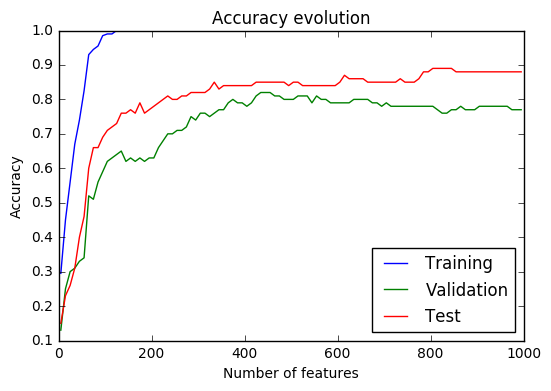

Number optimum of features: 435
The optimum test accuracy is  85.00%


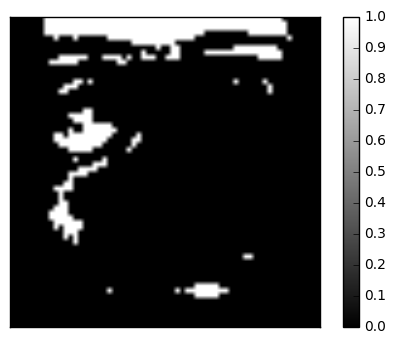

In [49]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(5, 1000, 10) # To speed up the execution, we use steps of 10 features.
X_train_s = X_train[:,ind_rel_feat]
X_val_s = X_val[:,ind_rel_feat]
X_test_s = X_test[:,ind_rel_feat]
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat)

# Plot it!
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(acc_val)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]


print 'Number optimum of features: ' + str(num_opt_feat)
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

# Create and plot the mask
mask = np.zeros(len(F))
mask[ind_rel_feat[0:num_opt_feat]] = 1
plt.figure()
plot_image(mask, h, w)
plt.show()

In [50]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(num_opt_feat,435, 'incorrect result: number of selected features is uncorrect')
Test.assertEquals(test_acc_opt,0.85, 'incorrect result: test error is uncorrect')

1 test passed.
1 test passed.


### ** Part 3: More advanced work **

Implement a search approach (either fordward or backward) to combine with any relevance criteria to be able to find the best subset of selected features